In [2]:
from langchain_community.embeddings import HuggingFaceBgeEmbeddings
from pprint import pprint
from pinecone import Pinecone
import os
import re
import json
from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain_community.document_loaders import WebBaseLoader
from langchain_community.vectorstores import Chroma
from langchain_openai import OpenAIEmbeddings
from langchain import hub
from langchain_core.output_parsers import StrOutputParser
from langchain_core.prompts import ChatPromptTemplate
from langchain_openai import ChatOpenAI
from langchain.tools import Tool
from langchain_community.tools.tavily_search import TavilySearchResults
from langchain.vectorstores import Pinecone as PL

from pydantic import BaseModel, Field
from langgraph.prebuilt import tools_condition
from langchain.schema import Document
from langgraph.checkpoint.memory import MemorySaver
from langgraph.graph import END, START, StateGraph
from langgraph.prebuilt import ToolNode

from typing import List
from typing_extensions import TypedDict

from dotenv import load_dotenv
load_dotenv()

os.environ["USER_AGENT"] = os.getenv("USER_AGENT")

In [3]:
model_name = "BAAI/bge-m3"

embedding_function = HuggingFaceBgeEmbeddings(
    model_name=model_name,
    model_kwargs={'device': 'cuda'},
    encode_kwargs={'normalize_embeddings': True}
)

urls = [
    "https://en.wikipedia.org/wiki/Computer_vision",
    "https://viso.ai/computer-vision/what-is-computer-vision/",
    "https://blog.theos.ai/articles/introduction-to-computer-vision#:~:text=Computer%20vision%20is%20composed%20of,and%20text%20to%20image%20generation",
    "https://www.geeksforgeeks.org/computer-vision-tasks/",
    "https://www.geeksforgeeks.org/introduction-convolution-neural-network/",
    "https://www.educative.io/answers/how-does-cnn-work-in-computer-vision-tasks"
]

docs = [WebBaseLoader(url).load() for url in urls]
docs_list = [item for sublist in docs for item in sublist]

# Split
text_splitter = RecursiveCharacterTextSplitter.from_tiktoken_encoder(
    chunk_size=500, chunk_overlap=0
)
doc_splits = text_splitter.split_documents(docs_list)

vectorstore = Chroma.from_documents(
    documents=doc_splits,
    collection_name="rag-chroma",
    embedding=embedding_function,
)
retriever = vectorstore.as_retriever()

In [12]:
def run_retriever(input_text):
    return retriever.invoke(input_text, k=3)

retriever_tool = Tool(
    name="retriever",
    func=run_retriever,
    description="Perform a retriever search to get information "
                "based on the query about Computer Vision(CV) "
                "and Convolution Neural Networks(CNN)"
)

web_search_tool = TavilySearchResults(k=3, tavily_api_key=os.getenv("TAVILY_API_KEY"))
web_search_tool = Tool(
    name="web_search",
    func=web_search_tool.run,
    description="Perform a web search to look for any questions that is "
                "unrelated to Computer Vision(CV) "
                "and Convolution Neural Networks(CNN)"
)

tools = [retriever_tool, web_search_tool]
model = ChatOpenAI(model='llama3.1', api_key='ollama', base_url='http://localhost:11434/v1/', temperature=0)
model_with_tools = model.bind_tools(tools)

# Run
question = "What is the CNN in CV?"
tool_result = model_with_tools.invoke(question)
pprint(tool_result)
print('\n')
question = "Who was the first man on the moon?"
tool_result = model_with_tools.invoke(question)
pprint(tool_result)

AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_h9i0cpus', 'function': {'arguments': '{"__arg1":"CNN in CV"}', 'name': 'retriever'}, 'type': 'function'}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 22, 'prompt_tokens': 252, 'total_tokens': 274, 'completion_tokens_details': None}, 'model_name': 'llama3.1', 'system_fingerprint': 'fp_ollama', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run-09552ded-b1b9-48b4-97d0-4e32f7685c7b-0', tool_calls=[{'name': 'retriever', 'args': {'__arg1': 'CNN in CV'}, 'id': 'call_h9i0cpus', 'type': 'tool_call'}], usage_metadata={'input_tokens': 252, 'output_tokens': 22, 'total_tokens': 274})

AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_tft5pabu', 'function': {'arguments': '{"__arg1":"Who was the first man on the moon?"}', 'name': 'web_search'}, 'type': 'function'}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 27, 'prompt_tokens': 254, 'total_toke

In [15]:
### Retrieval Grader
class GradeDocuments(BaseModel):
    """Binary score for relevance check on retrieved documents."""

    binary_score: str = Field(
        description="Documents are relevant to the question, 'yes' or 'no'"
    )
# Prompt
system = """You are a grader assessing relevance of a retrieved document to a user question. \n
    If the document contains keyword(s) or semantic meaning related to the user question, grade it as relevant. \n
    It does not need to be a stringent test. The goal is to filter out erroneous retrievals. \n
    Give a binary score 'yes' or 'no' score to indicate whether the document is relevant to the question."""
grade_prompt = ChatPromptTemplate.from_messages(
    [
        ("system", system),
        ("human", "Retrieved document: \n\n {document} \n\n User question: {question}"),
    ]
)

# LLM
llm = ChatOpenAI(model='llama3.1', api_key='ollama', base_url='http://localhost:11434/v1/', temperature=0)
structured_llm_grader = llm.with_structured_output(GradeDocuments)

# Chain
retrieval_grader = grade_prompt | structured_llm_grader

#Run
tool_name = tool_result.additional_kwargs.get('tool_calls')[0]['function']['name']
if tool_name =='retriever':
    docs = retriever.invoke(question)
    doc_txt = docs[0].page_content
    print(retrieval_grader.invoke({"question": question, "document": doc_txt}))
else:
    docs = web_search_tool.invoke(question)
    doc_txt = docs[0]['content']
    print(retrieval_grader.invoke({"question": question, "document": doc_txt}))

binary_score='yes'


In [14]:
### Generate

# Prompt
prompt = hub.pull("rlm/rag-prompt")

# LLM
llm = ChatOpenAI(model='llama3.1', api_key='ollama', base_url='http://localhost:11434/v1/', temperature=0)

# Post-processing
def format_docs(docs):
    return "\n\n".join(doc.page_content for doc in docs)

# Chain
rag_chain = prompt | llm | StrOutputParser()

#Run
if tool_name =='retriever':
    generation = rag_chain.invoke({"context": format_docs(docs), "question": question})
else:
    generation = rag_chain.invoke({"context": docs, "question": question})

print(generation)

Neil Armstrong was the first man on the moon. He stepped onto the lunar surface on July 20, 1969, as part of the Apollo 11 mission. His famous words upon setting foot on the moon were "That's one small step for [a] man, one giant leap for mankind."


In [16]:
### Hallucination Grader

# Data model
class GradeHallucinations(BaseModel):
    """Binary score for hallucination present in generation answer."""

    binary_score: str = Field(
        description="Answer is grounded in the facts, 'yes' or 'no'"
    )

# Prompt
system = """You are a grader assessing whether an LLM generation is grounded in / supported by some of retrieved facts. \n
     Give a binary score 'yes' or 'no'. 'yes' means that the answer is grounded in / supported by the set of facts. 'no' means absolutely wrong generation"""

hallucination_prompt = ChatPromptTemplate.from_messages(
    [
        ("system", system),
        ("human", "Set of facts: \n\n {documents} \n\n LLM generation: {generation}"),
    ]
)

# LLM
llm = ChatOpenAI(model='llama3.1', api_key='ollama', base_url='http://localhost:11434/v1/', temperature=0)
structured_llm_grader = llm.with_structured_output(GradeHallucinations)

# Chain
hallucination_grader = hallucination_prompt | structured_llm_grader

#Run
if tool_name =='retriever':
    docs_splitted = [d.page_content for d in docs]
else:
    docs_splitted = [d['content'] for d in docs]

print(hallucination_grader.invoke({"documents": docs_splitted, "generation": generation}))

binary_score='yes'


In [17]:
### Answer Grader

# Data model
class GradeAnswer(BaseModel):
    """Binary score to assess answer addresses question."""

    binary_score: str = Field(
        description="Answer addresses the question, 'yes' or 'no'"
    )

# Prompt
system = """You are a grader assessing whether an answer addresses / resolves a question \n
     Give a binary score 'yes' or 'no'. yes' means that the answer resolves the question."""
answer_prompt = ChatPromptTemplate.from_messages(
    [
        ("system", system),
        ("human", "User question: \n\n {question} \n\n LLM generation: {generation}"),
    ]
)

# LLM
llm = ChatOpenAI(model='interstellarninja/hermes-2-pro-llama-3-8b-tools:latest', api_key='ollama', base_url='http://localhost:11434/v1/', temperature=0)
structured_llm_grader = llm.with_structured_output(GradeAnswer)

# Chain
answer_grader = answer_prompt | structured_llm_grader

# Run
answer_score = answer_grader.invoke({"question": question, "generation": generation})
print(answer_score)

GradeAnswer(binary_score='yes')

In [18]:
### Question Re-writer

# Prompt
system = """You a question re-writer that converts an input question to a better version that is optimized \n
     for vectorstore retrieval. Look at the input and try to reason about the underlying semantic intent / meaning. Give strictly only the improved question without any additional words and thoughts from you."""

re_write_prompt = ChatPromptTemplate.from_messages(
    [
        ("system", system),
        (
            "human",
            "Here is the initial question: \n\n {question} \n Formulate an improved question.",
        ),
    ]
)

# LLM
llm = ChatOpenAI(model='llama3.1', api_key='ollama', base_url='http://localhost:11434/v1/', temperature=0)

# Chain
question_rewriter = re_write_prompt | llm | StrOutputParser()

# Run
question_rewriter.invoke({"question": question})

'What astronaut achieved the first lunar landing?'

Define Graph State

In [44]:
class ToolCall(TypedDict):
    id: str
    function: dict
    type: str


class GraphState(TypedDict):
    question: str
    generation: str
    generation_id: int
    docs_grade_id: int
    tool_cals: List[ToolCall]
    tool_name: str
    messages: List[str]
    chat_history: List[str]
    documents: List[str]

Define Graph Flow

In [50]:
def transform_query(state):
    """
    Transform the query to produce a better question.
    """
    print("---TRANSFORM QUERY---")

    question = state["question"]
    documents = state["documents"]
    # Re-write question
    better_question = question_rewriter.invoke({"question": question})

    print(f'question: {question}')
    print(f'\n')
    print(f'transformed question: {better_question}')
    return {"documents": documents, "question": better_question}


def decide_to_generate(state):
    """
    Determines whether to generate an answer, or re-generate a question.
    """
    print("---ASSESS GRADED DOCUMENTS---")

    filtered_documents = state["documents"]
    docs_grade_id = state["docs_grade_id"]

    if not filtered_documents:
        if docs_grade_id <= 3:
            print(
                "---DECISION: ALL DOCUMENTS ARE NOT RELEVANT TO QUESTION, TRANSFORM QUERY---"
            )
            return "transform_query"
        else:
            # To avoid a possible endless loop
            print(f"~~~~~The generation limit has been reached~~~~~")
            return 'limit'
    else:
        print("---DECISION: GENERATE---")
        return "generate"


def grade_generation_v_documents_and_question(state):
    """
    Determines whether the generation is grounded in the document and answers question.
    """
    print("---CHECK HALLUCINATIONS---")

    question = state["question"]
    documents = state["documents"]
    generation = state["generation"]
    generation_id = state["generation_id"]
    tool_name = state["tool_name"]

    if tool_name == "retriever":
        docs_splitted = documents
    else:
        docs_splitted = [d.page_content for d in documents]

    score = hallucination_grader.invoke(
        {"documents": docs_splitted, "generation": generation}
    )

    # Check hallucinations
    if score:
        grade = score.binary_score
        if grade == "yes":
            print("---DECISION: GENERATION IS GROUNDED IN DOCUMENTS---")
            # Check question-answering
            print("---GRADE GENERATION vs QUESTION---")
            score = answer_grader.invoke({"question": question, "generation": generation})
            print(f'score: {score}')
            if score:
                grade = score.binary_score
                if grade == "yes":
                    print("---DECISION: GENERATION ADDRESSES QUESTION---")
                    return "useful"
                else:
                    print("---DECISION: GENERATION DOES NOT ADDRESS QUESTION---")
                    return "not useful"
            # To avoid a possible endless loop
            print(f"~~~~~Failed answer grader~~~~~")
            return "failed"
        else:
            if generation_id <= 3:
                print("---DECISION: GENERATION IS NOT GROUNDED IN DOCUMENTS, RE-TRY---")
                return "not supported"
            else:
                # To avoid a possible endless loop
                print(f"~~~~~The generation limit has been reached~~~~~")
                return "limit"
    else:
        # To avoid a possible endless loop
        print(f"~~~~~Failed hallucination grader~~~~~")
        return "failed"


def generate(state):
    """
    Generate answer
    """
    print("---GENERATE---")

    question = state["question"]
    documents = state["documents"]
    chat_history = state["chat_history"]

    generation_id = state["generation_id"]
    generation_id += 1
    print(f'---> generate iteration:{generation_id}')

    # RAG generation
    generation = rag_chain.invoke({"context": documents, "question": question})
    chat_history.append([{
        "generation_id" : generation_id,
        "user_question" : question,
        "ai_answer" : generation
    }])
    return {"documents": documents, "question": question, "generation": generation, "generation_id": generation_id, "chat_history": chat_history}


def grade_documents(state):
    """
    Determines whether the retrieved documents are relevant to the question.
    """
    print("---CHECK DOCUMENT RELEVANCE TO QUESTION---")

    question = state["question"]
    messages = state['messages']
    tool_name = state['tool_name']
    docs_grade_id = state["docs_grade_id"]
    docs_grade_id +=1
    print(f'---> grade_documents iteration: {docs_grade_id}')

    if tool_name =='retriever':
        docs = messages[-1].content
        doc_strings = re.findall(r'Document\(metadata=(.+?), page_content=(.+?)\)', docs)
        documents = []
        for metadata_str, page_content_str in doc_strings:
            metadata = eval(metadata_str)
            page_content = page_content_str.strip("'")
            doc = Document(page_content=page_content, metadata=metadata)
            documents.append(doc)
    else:
        tool_message_content = messages[-1].content
        parsed_content = json.loads(tool_message_content)
        documents = [Document(page_content=item["content"], metadata={"source": item["url"]}) for item in parsed_content]

    # Score each doc
    filtered_docs = []
    for d in documents:
        score = retrieval_grader.invoke(
            {"question": question, "document": d.page_content}
        )
        grade = score.binary_score
        if grade == "yes":
            print("---GRADE: DOCUMENT RELEVANT---")
            filtered_docs.append(d)
        else:
            print("---GRADE: DOCUMENT NOT RELEVANT---")
            continue
    return {"documents": filtered_docs, "question": question, "docs_grade_id":docs_grade_id}

In [51]:
# Agent
def agent(state):
    """
    Invokes the agent model to generate a response based on the current state. Given
    the question, it will decide to retrieve using the retriever tool, or simply end.
    """
    print("---CALL AGENT---")
    question = state["question"]
    messages = state.get("messages", [])
    generation_id = state.get("generation_id", 0)
    docs_grade_id = state.get("docs_grade_id", 0)

    model = ChatOpenAI(model='llama3.1', api_key='ollama', base_url='http://localhost:11434/v1/', temperature=0)
    model = model.bind_tools(tools)
    response = model.invoke(question)
    messages.append(response)

    tool_name = response.additional_kwargs.get('tool_calls')[0]['function']['name']
    print(f'called ----> TOOL NAME ---> {tool_name}')
    return {
        "generation": response,
        "messages": messages,
        "tool_name": tool_name,
        "tool_calls": state.get("tool_calls", []),
        "question": state["question"],
        "generation_id": generation_id,
        "docs_grade_id": docs_grade_id,
        "documents": state.get("documents", []),
        "chat_history": state.get("chat_history", [])
    }

In [52]:
# Workflow
workflow = StateGraph(GraphState)

# Define the nodes
workflow.add_node("agent", agent)
tool_node = ToolNode(tools)
workflow.add_node("action", tool_node)
workflow.add_node("grade_documents", grade_documents)
workflow.add_node("generate", generate)
workflow.add_node("transform_query", transform_query)

# Build graph
workflow.add_edge(START, "agent")
workflow.add_conditional_edges(
    "agent",
    tools_condition,
    {
        "tools": "action"
    },
)
workflow.add_edge("action", "grade_documents")
workflow.add_conditional_edges(
    "grade_documents",
    decide_to_generate,
    {
        "transform_query": "transform_query",
        "generate": "generate",
        "limit": END
    },
)
workflow.add_edge("transform_query", "agent")
workflow.add_conditional_edges(
    "generate",
    grade_generation_v_documents_and_question,
    {
        "not supported": "generate",
        "failed": END,
        "limit": END,
        "useful": END,
        "not useful": "transform_query",
    },
)

# Compile
app = workflow.compile()

In [26]:
# Run
inputs = {
    "question": "What are Computer Vision tasks?",
    # "question": "Who was the first man on the moon?",
}
for output in app.stream(inputs):
    for key, value in output.items():
        # Node
        pprint(f"Node '{key}':")
        # Optional: print full state at each node
        # pprint.pprint(value["keys"], indent=2, width=80, depth=None)
    pprint("\n---\n")

# Final generation
if len(value["documents"])!=0:
    pprint(value["generation"])
else:
    pprint(value)

---CALL AGENT---
called ----> TOOL NAME ---> retriever
"Node 'agent':"
'\n---\n'
"Node 'action':"
'\n---\n'
---CHECK DOCUMENT RELEVANCE TO QUESTION---
---GRADE: DOCUMENT RELEVANT---
---GRADE: DOCUMENT RELEVANT---
---GRADE: DOCUMENT NOT RELEVANT---
---GRADE: DOCUMENT NOT RELEVANT---
---ASSESS GRADED DOCUMENTS---
---DECISION: GENERATE---
"Node 'grade_documents':"
'\n---\n'
---GENERATE---
---> generation_id:1
---CHECK HALLUCINATIONS---
---DECISION: GENERATION IS GROUNDED IN DOCUMENTS---
---GRADE GENERATION vs QUESTION---
score: binary_score='yes'
---DECISION: GENERATION ADDRESSES QUESTION---
"Node 'generate':"
'\n---\n'
('Computer Vision tasks include Image Classification, Object Detection, Image '
 'Segmentation, Face and Person Recognition, Edge Detection, Image '
 'Restoration, Feature Matching, Scene Reconstruction, and Video Motion '
 'Analysis. These tasks help computers understand and analyze visual data from '
 'digital images, videos, and similar visual inputs. They play a critic

In [27]:
pprint(value['chat_history'])

[[{'ai_answer': 'Computer Vision tasks include Image Classification, Object '
                'Detection, Image Segmentation, Face and Person Recognition, '
                'Edge Detection, Image Restoration, Feature Matching, Scene '
                'Reconstruction, and Video Motion Analysis. These tasks help '
                'computers understand and analyze visual data from digital '
                'images, videos, and similar visual inputs. They play a '
                'critical role in areas such as image recognition and object '
                'detection.',
   'generation_id': 1,
   'user_question': 'What are Computer Vision tasks?'}]]


In [32]:
# Run
inputs = {
    "question": "What is the generation Z ?",
}
for output in app.stream(inputs):
    for key, value in output.items():
        # Node
        pprint(f"Node '{key}':")
    pprint("\n---\n")

# Final generation
if len(value["documents"])!=0:
    pprint(value["generation"])
else:
    pprint(value)

---CALL AGENT---
called ----> TOOL NAME ---> web_search
"Node 'agent':"
'\n---\n'
"Node 'action':"
'\n---\n'
---CHECK DOCUMENT RELEVANCE TO QUESTION---
---GRADE: DOCUMENT RELEVANT---
---GRADE: DOCUMENT RELEVANT---
---GRADE: DOCUMENT RELEVANT---
---GRADE: DOCUMENT RELEVANT---
---GRADE: DOCUMENT NOT RELEVANT---
---ASSESS GRADED DOCUMENTS---
---DECISION: GENERATE---
"Node 'grade_documents':"
'\n---\n'
---GENERATE---
---> generation_id:1
---CHECK HALLUCINATIONS---
---DECISION: GENERATION IS GROUNDED IN DOCUMENTS---
---GRADE GENERATION vs QUESTION---
score: binary_score='yes'
---DECISION: GENERATION ADDRESSES QUESTION---
"Node 'generate':"
'\n---\n'
('Gen Z is the most racially and ethnically diverse generation of Americans, '
 'with non-Hispanic White Gen Zers holding a slim majority at 52%. They grew '
 'up in the era of smartphones, climate change awareness, and pandemic '
 'lockdowns, shaping their behaviors and values. This generation is '
 'characterized by being more pragmatic, cauti

In [33]:
pprint(value['chat_history'])

[[{'ai_answer': 'Gen Z is the most racially and ethnically diverse generation '
                'of Americans, with non-Hispanic White Gen Zers holding a slim '
                'majority at 52%. They grew up in the era of smartphones, '
                'climate change awareness, and pandemic lockdowns, shaping '
                'their behaviors and values. This generation is characterized '
                'by being more pragmatic, cautious, and digitally savvy than '
                'previous generations.',
   'generation_id': 1,
   'user_question': 'What is the generation Z ?'}]]


In [53]:
# Run
inputs = {
    "question": "What is the slknskd?",
}

for output in app.stream(inputs):
    for key, value in output.items():
        # Node
        pprint(f"Node '{key}':")
    pprint("\n---\n")

# Final generation
if len(value["documents"])!=0:
    pprint(value["generation"])
else:
    pprint(value)

---CALL AGENT---
called ----> TOOL NAME ---> web_search
"Node 'agent':"
'\n---\n'
"Node 'action':"
'\n---\n'
---CHECK DOCUMENT RELEVANCE TO QUESTION---
---> grade_documents iteration: 1
---GRADE: DOCUMENT NOT RELEVANT---
---GRADE: DOCUMENT NOT RELEVANT---
---GRADE: DOCUMENT NOT RELEVANT---
---GRADE: DOCUMENT NOT RELEVANT---
---GRADE: DOCUMENT NOT RELEVANT---
---ASSESS GRADED DOCUMENTS---
---DECISION: ALL DOCUMENTS ARE NOT RELEVANT TO QUESTION, TRANSFORM QUERY---
"Node 'grade_documents':"
'\n---\n'
---TRANSFORM QUERY---
question: What is the slknskd?


transformed question: What are the keywords or concepts related to "slknskd"?
"Node 'transform_query':"
'\n---\n'
---CALL AGENT---
called ----> TOOL NAME ---> web_search
"Node 'agent':"
'\n---\n'
"Node 'action':"
'\n---\n'
---CHECK DOCUMENT RELEVANCE TO QUESTION---
---> grade_documents iteration: 2
---GRADE: DOCUMENT NOT RELEVANT---
---GRADE: DOCUMENT NOT RELEVANT---
---GRADE: DOCUMENT NOT RELEVANT---
---GRADE: DOCUMENT NOT RELEVANT---
--

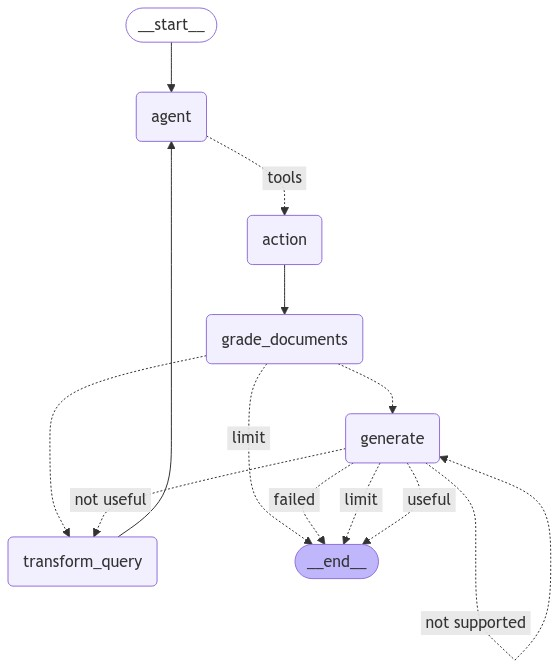

In [54]:
from IPython.display import Image, display

try:
    display(Image(app.get_graph(xray=True).draw_mermaid_png()))
except Exception:
    pass